## Задание 8.1

In [174]:
%matplotlib inline  
import scipy.stats as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
import csv
import random

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

Прочитаем данные, заменим координату month на индикатор летнего сезона. А поле day не будем использовать, чтобы оно не участовало в построеннии линейной модели. Добавим поле единиц для обусловленности матрицы. Перемешаем данные.

In [175]:
data = pd.read_csv('forestfires.csv')
summer = ['jun', 'jul', 'aug']
data.insert(2, 'summer', [int(i in summer) for i in data['month']])

data.drop(['day','month'], axis=1, inplace=True)

def shuffle_me(data):    
    shuffle_data = data.copy()
    shuffle_data.insert(0, 'ones', 1)
    shuffle_data = shuffle_data.iloc[np.random.permutation(len(data))]
    area = shuffle_data.area.copy()
    shuffle_data.drop('area', axis=1, inplace=True)
    return shuffle_data, area

shuffle_data, area = shuffle_me(data)
print("Седьмая часть от всей выборки: " + str(round(7*len(area)/10)))

Седьмая часть от всей выборки: 362


In [176]:
train = shuffle_data[:362]
area_train = area[:362]
test = shuffle_data[363:]
area_test = area[363:]

Построим регрессионную модель по первой части выборки.

$X = Z\theta +\varepsilon$. Найдем оценку коэффициентов линейной регрессии методом наименьших квадратов:

$\hat{\theta} = (Z^TZ)^{-1}Z^TX$, где X - вектoр данных area, Z - матрица остальных данных.

In [177]:
class regression():
    def __init__(self):
        pass
    
    def fit(self, Z, X):
        temp = np.dot(np.linalg.inv(np.dot(Z.T, Z)), Z.T)
        self.c = np.dot(temp, X)
        
    def predic(self, Z):
        return np.dot(Z, self.c)
    def mse(self, predic, test):
        return (np.mean(np.array(predic) - np.array(test))**2)

In [178]:
reg = regression()
reg.fit(train.as_matrix(), area_train.as_matrix())
predic = reg.predic(test.as_matrix())
X = area_test.as_matrix()

print (reg.mse(predic, area_test.as_matrix()))

16.10650325860489


Дисперсия равна 16.11

Сделаем для area преобразование $f(x) = ln(c+x)$ и построим для нее регрессионную модель. Посчитаем среднеквадратичную ошибку для преобразованных значений по данному правилу и для исходных, применив в последнем случае к оценкам обратное к f преобразование.Найдем коэффициент при котором предсказания получаются лучше всего.

### Для фиксированного сплита данных

Для фиксированного разбиения выборки, обучаем модель на преобразованных значениях $newarea = f(area) = log(area+c)$ на $train$,
затем предсказываем значения на $test$, делаем обратное преобразование для предсказанных значений и считаем среднеквадратичную ошибку с правильными ответами area_test;
Находим $c$, преобразование с которым дает наименьшую ошибку.

In [179]:
train = shuffle_data[:362]
area_train = area[:362]
test = shuffle_data[363:]
area_test = area[363:]


c_results = []
x_range = range(1,200)

for c in x_range:
    reg.fit(train.as_matrix(), np.log(area_train.as_matrix()+c) )
    temp_predic = reg.predic(test.as_matrix())
    temp_result = reg.mse((temp_predic), np.log(area_test.as_matrix() + c))
    c_results.append(temp_result)


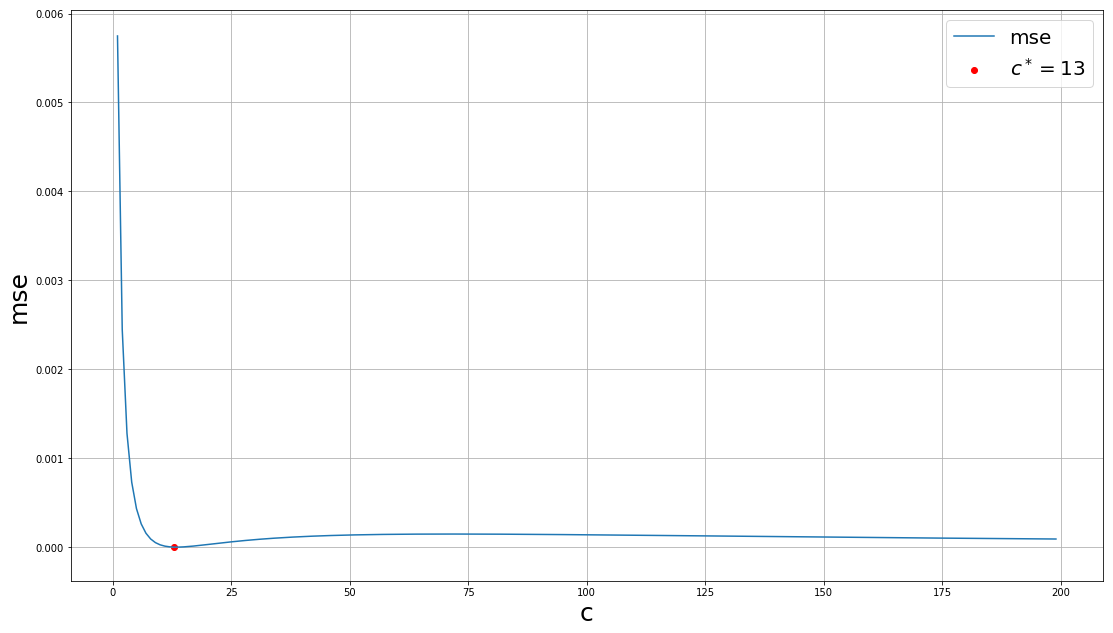

In [180]:
plt.plot(x_range, c_results, label = 'mse')
plt.scatter(np.argmin(c_results)+1, min(c_results), c='r', label=r'$c^* = $' +str(np.argmin(c_results)+1))
plt.xlabel("c", fontsize=25)
plt.ylabel("mse", fontsize=25)
fig = plt.gcf()
plt.grid(True)
fig.set_size_inches(18.5, 10.5)
plt.legend( fontsize=20)
plt.show()

Будем генерировать случайные разбиения данных и смотреть на mse с преобразованнымми значениями для выбранного параметра $c=13$

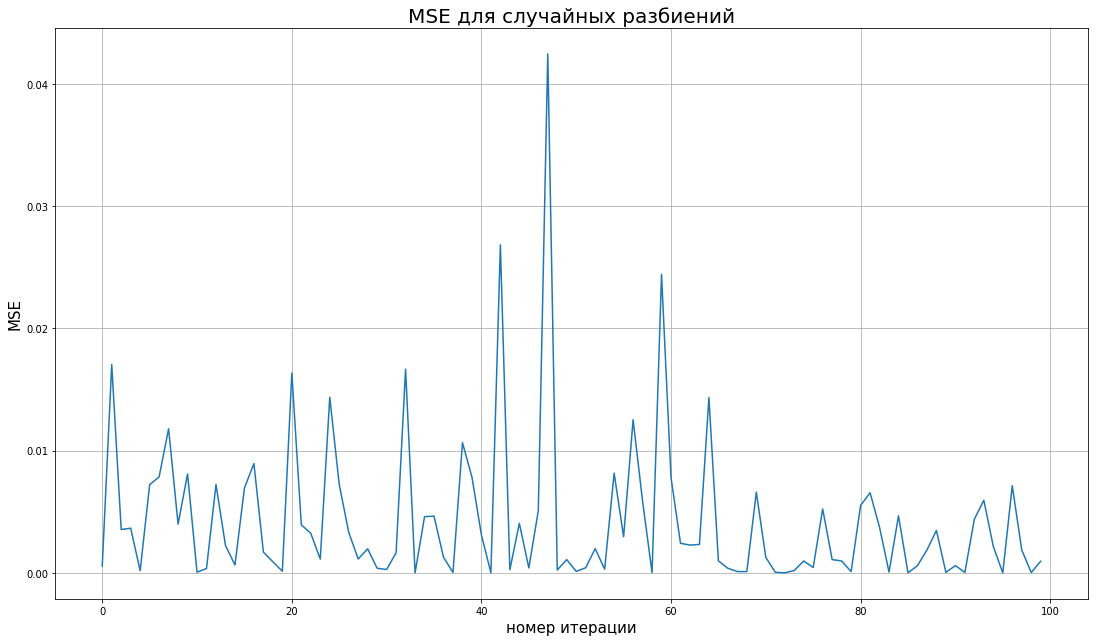

In [188]:
shuffle_results = []
c_min = 13

for i in range(100):
    shuffle_data, area = shuffle_me(data)
    train = shuffle_data[:362]
    area_train = area[:362]
    test = shuffle_data[363:]
    area_test = area[363:]
    reg.fit(train.as_matrix(), np.log(area_train.as_matrix()+c_min) )
    temp_predic = reg.predic(test.as_matrix())
    temp_result = reg.mse(temp_predic, np.log(area_test.as_matrix()+c_min))
    shuffle_results.append(temp_result)

plt.plot(range(100), shuffle_results)
plt.title("MSE для случайных разбиений", fontsize=20)
plt.ylabel("MSE", fontsize=15)
plt.xlabel("номер итерации", fontsize=15)
fig = plt.gcf()
plt.grid(True)
fig.set_size_inches(18.5, 10.5)
plt.show()

Теперь попробуем построить график дисперсии без преобразований при случайных разбиениях

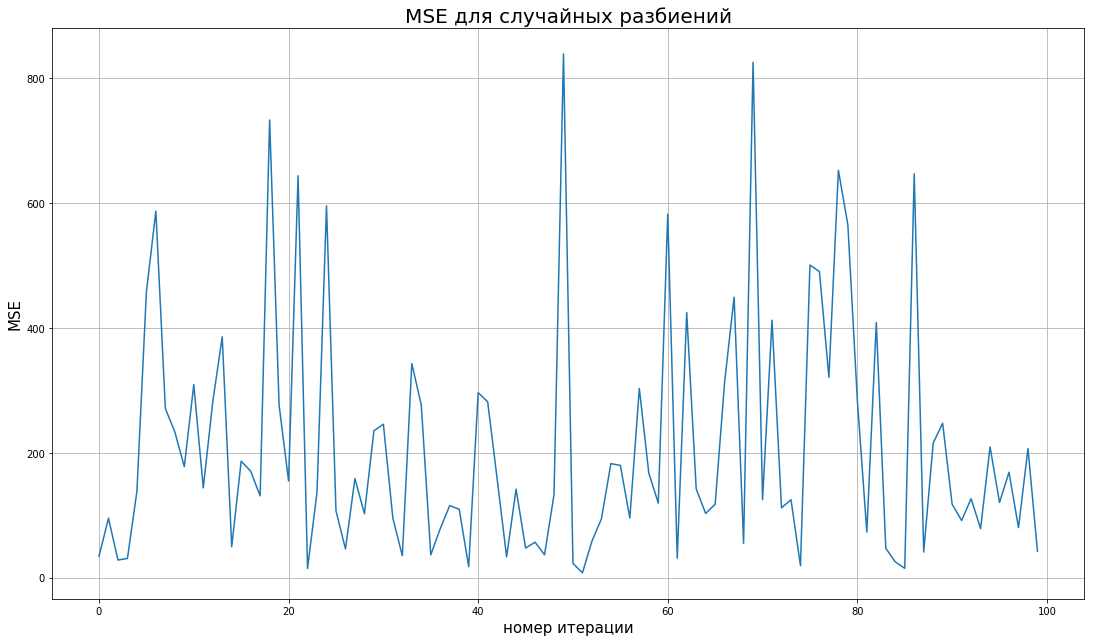

In [187]:
shuffle_results = []

for i in range(100):
    shuffle_data, area = shuffle_me(data)
    train = shuffle_data[:362]
    area_train = area[:362]
    test = shuffle_data[363:]
    area_test = area[363:]
    reg.fit(train.as_matrix(), area_train.as_matrix() )
    temp_predic = reg.predic(test.as_matrix())
    temp_result = reg.mse(temp_predic, area_test.as_matrix()+c_min)
    shuffle_results.append(temp_result)

plt.plot(range(100), shuffle_results)
plt.title("MSE для случайных разбиений", fontsize=20)
plt.ylabel("MSE", fontsize=15)
plt.xlabel("номер итерации", fontsize=15)
fig = plt.gcf()
plt.grid(True)
fig.set_size_inches(18.5, 10.5)
plt.show()

## Вывод

Как можно заметить дисперсия очень зависит от того как данные разделились на тестовые и тренировочные. 
Приведенное преобразование призвано уменьшить промежуток между большими по сравнению с нулями значениями, выровнять распределение $y$. Но для каждого случайного сплита это распределение получается разное и потому невозможно подобрать параметр, который уменьшит дисперсию при любой выборке. Таким образом данную задачу решать методом линейной регрессии не совсем оправдано, так как этот метод дает очень большую дисперсию на тестовых данных при случайном сплите. Возможно, если брать данные в хронолигическом порядке данный метод отработает лучше. Далее можно увидеть, действительно дисперсия стала меньше на упорядоченных данных.

In [193]:
def noshuffle_me(data):    
    shuffle_data = data.copy()
    shuffle_data.insert(0, 'ones', 1)
    area = shuffle_data.area.copy()
    shuffle_data.drop('area', axis=1, inplace=True)
    return shuffle_data, area

shuffle_data, area = noshuffle_me(data)
print("Седьмая часть от всей выборки: " + str(round(7*len(area)/10)))
train = shuffle_data[:362]
area_train = area[:362]
test = shuffle_data[363:]
area_test = area[363:]
reg = regression()
reg.fit(train.as_matrix(), area_train.as_matrix())
predic = reg.predic(test.as_matrix())
X = area_test.as_matrix()

print ("Дисперсия в случае хронологического порядка " + str(reg.mse(predic, area_test.as_matrix())))

Седьмая часть от всей выборки: 362
Дисперсия в случае хронологического порядка 4.162762505869449
